# Fase 2 - SVM con ngrams (in-genre classification)

Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata su n-grammi di caratteri, parole e part-of-speech. Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto alla lunghezza degli ngrammi utilizzati e/o rispetto al tipo di informazione utilizzata all’interno degli ngrammi (forme, lemmi, caratteri, part-of-speech) e valutare i diversi sistemi con un
processo di 5-fold cross validation condotto sul training set;
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra.

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

In [1]:
# Importazioni necessarie
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC

In [2]:
# Carica i documenti e le annotazioni
conllu_dir = "../../data/profiling_output/diary/linguistic_annotation/diary/"

In [3]:
# Definizione delle classi per la gestione dei documenti
class Document:
    """Classe per rappresentare un documento con le sue frasi e metadati."""
    def __init__(self, document_path):
        self.document_path = document_path
        self._parse_doc_info(document_path)
        self.sentences = []
        self.features = None
    
    """ Estrae informazioni dal nome del file .conllu. """
    def _parse_doc_info(self, document_path):
        document_path = document_path.split('/')[-1]
        document_info = document_path.split('.')[0].split('#')
        self.split = document_info[0]
        self.doc_id = document_info[1]
        self.genre = document_info[2]
        self.gender = document_info[3]

    """ Aggiunge un oggetto Sentence alla lista self.sentences. """
    def add_sentence(self, sentence):
        self.sentences.append(sentence)
    
    # Per dopo
    """ Conta il totale dei token nel documento, sommando quelli delle frasi. """
    def get_num_tokens(self):
        num_words = 0
        for sentence in self.sentences:
            num_words += sentence.get_num_tokens()
        return num_words

    """ Conta il totale dei caratteri nel documento, sommando quelli delle frasi. """
    def get_num_chars(self):
        num_chars = 0
        for sentence in self.sentences:
            num_chars += sentence.get_num_chars()
        return num_chars

In [4]:
class Sentence:
    def __init__(self):
        self.tokens = [] # Inizializza una Sentence (frase) vuota con self.tokens = [] che conterrà i token della frase
    
    def add_token(self, token):
        self.tokens.append(token) # Aggiunge un oggetto tokens
    
    def get_words(self):
        return [token.word for token in self.tokens] # Restituisce una lista delle parole nella frase
    
    def get_lemmas(self):
        return [token.lemma for token in self.tokens] # Restituisce una lista dei lemmi della frase
    
    def get_pos(self):
        return [token.pos for token in self.tokens] # Restituisce una lista dei PoS-tag della frase
    
    def get_num_tokens(self): 
        return len(self.tokens) # Restituisce il numero di token nella frase 
    
    def get_num_chars(self):
        num_chars = 0
        for token in self.tokens:
            num_chars += token.get_num_chars()
        num_chars += self.get_num_tokens() - 1 # Contiamo anche gli spazi
        return num_chars
    
    def __str__(self):
        return ' '.join([token.word for token in self.tokens])
        # Converte l'oggetto Sentence in una stringa leggibile, restituendo la frase completa.

In [5]:
class Token:
    def __init__(self, word, lemma, pos):
        self.word = word
        self.lemma = lemma
        self.pos = pos
    
    def get_num_chars(self):
        return len(self.word) # Restituisce il numero di caratteri della parola.

In [6]:
# Funzione per caricare le frasi di un documento
def load_document_sentences(document):
    sentence = Sentence()
    for line in open(document.document_path, 'r', encoding='MacRoman'):
        if line[0].isdigit(): # se la riga inizia con un numero, che in .conllu indica un token (se la riga non inizia con un numero vuol dire che contiene info extra, come ad esempio # text = o # sent_id
            splitted_line = line.strip().split('\t') # rimuove spazi e divide la riga in colonne usando \t
            # esempio di riga divisa in colonne splitted_line = ['1', 'dobbiamo', 'dovere', 'AUX', 'VM', ...]
            
            if '-' not in splitted_line[0]:  # se l'id della parola non contiene un trattino
                # Esclude le preposizioni articolate (multitoken: della, negli, sul) che in .conllu sono scritte con -.
                
                token = Token(splitted_line[1], splitted_line[2], splitted_line[3])
                '''
                Crea un oggetto Token(word, lemma, pos) con:
                    splitted_line[1] → Parola (dobbiamo)
                    splitted_line[2] → Lemma (dovere) 
                    splitted_line[3] → PoS (parte del discorso) (AUX)
                '''
                sentence.add_token(token) # aggiungo il token alla frase corrente
        if line == '\n': # se la riga è vuota significa che la frase è finita, perché nel file conllu le frasi sono separate da righe vuote
            document.add_sentence(sentence)
            sentence = Sentence() # crea un nuovo oggetto per iniziare una nuova frase

In [7]:
# Carica i file .conllu
all_documents = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    if os.path.isfile(file_path): 
        document = Document(file_path)
        load_document_sentences(document)
        all_documents.append(document)

In [8]:
# Funzione per estrarre n-grammi da una frase
def extract_word_ngrams_from_sentence(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole
    if el == 'word':
        all_words = sentence.get_words()
    elif el == 'lemma':
        all_words = sentence.get_lemmas()
    elif el == 'pos':
        all_words = sentence.get_pos()
    else:
        raise Exception(f'Invalid element {el}')

    # scorriamo la lista delle parole ed estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1):  # -n+1 serve per non uscire dal vettore
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1
    
    return word_ngrams

In [9]:
def extract_char_ngrams_from_sentence(char_ngrams, sentence, n):
    # creiamo una lista con tutte le parole
    all_words = sentence.get_words()

    # creiamo una stringa che contenga tutte le parole separate tra spazi perché vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)
    
    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1
    
    return char_ngrams

In [10]:
# Funzione per estrarre n-grammi da tutti i documenti
def extract_documents_ngrams_normalized(all_documents, ngram_type='word', ngram_length=1):
    for document in all_documents:
        ngrams_dict = dict()
        for sentence in document.sentences:
            if ngram_type == 'word':
                extract_word_ngrams_from_sentence(ngrams_dict, sentence, 'word', ngram_length)
            elif ngram_type == 'lemma':
                extract_word_ngrams_from_sentence(ngrams_dict, sentence, 'lemma', ngram_length)
            elif ngram_type == 'pos':
                extract_word_ngrams_from_sentence(ngrams_dict, sentence, 'pos', ngram_length)
            elif ngram_type == 'char':
                extract_char_ngrams_from_sentence(ngrams_dict, sentence, ngram_length)
        
        num_words = document.get_num_tokens()
        num_chars = document.get_num_chars()
        normalize_ngrams(ngrams_dict, num_words if ngram_type != 'char' else num_chars)
        
        document.features = ngrams_dict

In [11]:
# Funzione per normalizzare le feature
def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram] / float(doc_len)

In [12]:
# Funzione per dividere il dataset in training e test set
def train_test_split(all_documents): 
    train_features_dict = [] # Lista dei dizionari di feature per il training
    train_labels = []  # Lista delle etichette di training (M/F)
    test_features_dict, test_labels = [], []

    for document in all_documents:
        if document.split == "training" and document.gender != "UNKNOWN":  # Usa direttamente document.split invece di estrarre dal path
            train_features_dict.append(document.features)
            train_labels.append(document.gender) # Usa gender come etichetta
        
        elif document.split == "test":
            test_features_dict.append(document.features)
            test_labels.append(document.gender) # Usa gender come etichetta

    return train_features_dict, train_labels, test_features_dict, test_labels

In [13]:
# Funzione per caricare i veri valori del genere dal file test_DI.gold
def load_gold_labels(file_path):
    gold_labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            doc_id, gender = line.strip().split()
            gold_labels[int(doc_id)] = gender
    return gold_labels

In [14]:
# Funzione per filtrare le feature poco frequenti
def filter_features(train_features_dict, min_occurrences):
    features_counter = dict() # Conto il numero di documenti in cui appare ogni features
    for document_features_dict in train_features_dict:
        for feature in document_features_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1
    
    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" utenti
    for document_features_dict in train_features_dict:
        document_features = list(document_features_dict.keys())
        for feature in document_features:
            if features_counter[feature] < min_occurrences:
                document_features_dict.pop(feature)

    return train_features_dict

In [15]:
# Definizione delle configurazioni di n-grammi da testare
ngram_types = ['word', 'lemma', 'pos', 'char']
ngram_lengths = [1, 2, 3]

In [16]:
# Variabili per memorizzare i risultati migliori
best_accuracy = 0
best_config = None

In [17]:
# Ciclo per testare diverse configurazioni di n-grammi
for ngram_type in ngram_types:
    for ngram_length in ngram_lengths:
        print(f"RISULTATI DELLE FOLD PER NGRAMMI DI TIPO {ngram_type} DI LUNGHEZZA {ngram_length}")
        
        # Estrai le feature e normalizza
        extract_documents_ngrams_normalized(all_documents, ngram_type, ngram_length)
        
        # Dividi il dataset in training e test set
        train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)
        
        # Filtra le feature poco frequenti
        train_features_dict = filter_features(train_features_dict, 5)
        
        # Crea il vettore delle feature
        vectorizer = DictVectorizer()
        X_train = vectorizer.fit_transform(train_features_dict)
        X_test = vectorizer.transform(test_features_dict)
        
        # Normalizza le feature
        scaler = MaxAbsScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # 5-fold cross-validation
        y_train = np.asarray(train_labels)
        splitter = KFold(n_splits=5, random_state=42, shuffle=True)
        folds = list(splitter.split(X_train))
        
        # Variabili per raccogliere risultati complessivi
        all_y_true = []
        all_y_pred = []
        
        # 5-fold cross-validation
        for i in range(len(folds)):
            train_ids, test_ids = folds[i]
            fold_X_train = X_train[train_ids]
            fold_y_train = y_train[train_ids]
            fold_X_test = X_train[test_ids]
            fold_y_test = y_train[test_ids]
            
            # Normalizzazione dentro ogni fold (solo con i dati di training del fold)
            scaler = MaxAbsScaler()
            fold_X_train = scaler.fit_transform(fold_X_train)
            fold_X_test = scaler.transform(fold_X_test)
            
            # Addestramento del modello SVM
            kfold_svc = LinearSVC(dual=False)
            kfold_svc.fit(fold_X_train, fold_y_train)
            fold_y_pred = kfold_svc.predict(fold_X_test)
            
            fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)
            
            # Baseline con Dummy Classifier
            dummy_clf = DummyClassifier(strategy="most_frequent")
            dummy_clf.fit(fold_X_train, fold_y_train)
            dummy_score = dummy_clf.score(fold_X_test, fold_y_test)
            
            all_y_true += fold_y_test.tolist()
            all_y_pred += fold_y_pred.tolist()
            
            print(f"Accuracy fold {i+1}: {fold_accuracy:.4f} \t Baseline dummy: {dummy_score:.4f}")
        
        # Calcola l'accuracy media su tutte le fold
        average_accuracy = accuracy_score(all_y_true, all_y_pred)
        
        # Report complessivo
        print(f"\nREPORT FINALE DELLA CROSS VAL. CON NGRAMMI DI TIPO {ngram_type} DI LUNGHEZZA {ngram_length} ")
        print(classification_report(all_y_true, all_y_pred, zero_division=0))
        print("\n")
        # Aggiorna la migliore configurazione
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_config = (ngram_type, ngram_length)

RISULTATI DELLE FOLD PER NGRAMMI DI TIPO word DI LUNGHEZZA 1
Accuracy fold 1: 0.8250 	 Baseline dummy: 0.4500
Accuracy fold 2: 0.7750 	 Baseline dummy: 0.4750
Accuracy fold 3: 0.8750 	 Baseline dummy: 0.5000
Accuracy fold 4: 0.7250 	 Baseline dummy: 0.4500
Accuracy fold 5: 0.7500 	 Baseline dummy: 0.4750

REPORT FINALE DELLA CROSS VAL. CON NGRAMMI DI TIPO word DI LUNGHEZZA 1 
              precision    recall  f1-score   support

           F       0.80      0.77      0.79       100
           M       0.78      0.81      0.79       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



RISULTATI DELLE FOLD PER NGRAMMI DI TIPO word DI LUNGHEZZA 2
Accuracy fold 1: 0.6500 	 Baseline dummy: 0.4500
Accuracy fold 2: 0.6250 	 Baseline dummy: 0.4750
Accuracy fold 3: 0.8000 	 Baseline dummy: 0.5000
Accuracy fold 4: 0.6250 	 Baseline dummy: 0.4500
Accuracy fold 5: 0.6250 	 Baseline 

In [18]:
# Stampare la migliore configurazione
print(f"Best configuration: {best_config} with average accuracy: {best_accuracy:.4f}")

Best configuration: ('char', 3) with average accuracy: 0.8300


In [19]:
# Valutazione sul test set con la migliore configurazione
ngram_type, ngram_length = best_config
extract_documents_ngrams_normalized(all_documents, ngram_type, ngram_length)
train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)
train_features_dict = filter_features(train_features_dict, 5)

In [20]:
# Crea il vettore delle feature
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
X_test = vectorizer.transform(test_features_dict)

In [21]:
# Normalizza le feature
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Addestra il modello SVM
final_svc = LinearSVC(dual=False)
final_svc.fit(X_train, train_labels)
test_predictions = final_svc.predict(X_test)

In [23]:
# Carica i veri valori del genere
gold_labels = load_gold_labels("../../data/dataset_originale/gold/test_DI.gold")
true_labels = [gold_labels[int(doc.doc_id)] for doc in all_documents if doc.split == "test"]

In [24]:
# Calcolo dell'accuratezza e confronto con baseline
final_accuracy = accuracy_score(true_labels, test_predictions)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, train_labels)
dummy_score = dummy_clf.score(X_test, true_labels)

print(f"=== Valutazione finale sul test set ===")
print(f"Accuracy finale SVM: {final_accuracy:.4f}")
print(f"Baseline Dummy Classifier: {dummy_score:.4f}")

=== Valutazione finale sul test set ===
Accuracy finale SVM: 0.5946
Baseline Dummy Classifier: 0.5000


In [25]:
# Report di classificazione
print("=== Report di classificazione ===")
print(classification_report(true_labels, test_predictions, zero_division=0))

=== Report di classificazione ===
              precision    recall  f1-score   support

           F       0.64      0.43      0.52        37
           M       0.57      0.76      0.65        37

    accuracy                           0.59        74
   macro avg       0.61      0.59      0.58        74
weighted avg       0.61      0.59      0.58        74



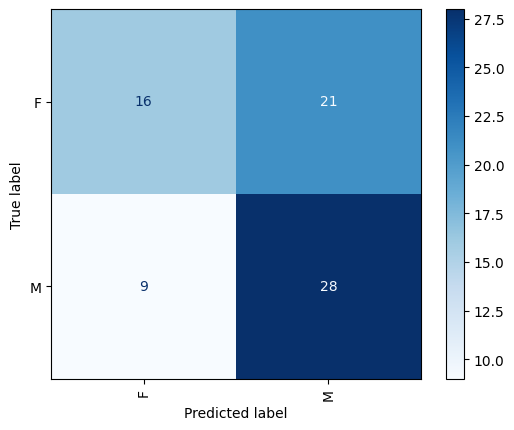

In [26]:
# Mostra la matrice di confusione
ConfusionMatrixDisplay.from_predictions(true_labels, test_predictions, xticks_rotation='vertical', cmap='Blues')